### Analysis of buyers' purchases.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
transactions = pd.read_csv('../personalized-fashion-recommendations/transactions_train.csv')
transactions.shape

(31788324, 5)

In [3]:
print(transactions['t_dat'].min(), transactions['t_dat'].max())
#2018-09-20 2020-09-22
split_date = '2020-09-16'
train_set = transactions[transactions['t_dat']<split_date]
test_set = transactions[transactions['t_dat']>=split_date]

2018-09-20 2020-09-22


In [4]:
len(train_set), len(test_set)

(31548013, 240311)

In [8]:
# let's take a chunk from test_set, but at the same time keep the proportion of users who:
# - were found in train_set (users with history),
# - were not found in train_set (new users).

# 1. For those are in train set. 
train_users = set(train_set["customer_id"].unique())

test_old = test_set[test_set["customer_id"].isin(train_users)]
test_new = test_set[~test_set["customer_id"].isin(train_users)]

# 2. 
p_old = len(test_old) / len(test_set)
p_new = len(test_new) / len(test_set)
print(f"Users with history of purchases: {p_old:.2%}, New users: {p_new:.2%}")

# 3. rebuilding keep proportions. 
chunk_size = 10000  # How many records of  transactions is valuable? 
n_old = int(chunk_size * p_old)
n_new = chunk_size - n_old

chunk_old = test_old.sample(n_old, random_state=42)
chunk_new = test_new.sample(n_new, random_state=42)

chunk_of_test_set = pd.concat([chunk_old, chunk_new], ignore_index=True)

print(chunk_of_test_set.shape)

Users with history of purchases: 92.45%, New users: 7.55%
(10000, 5)


In [33]:
test_set["customer_id"].nunique()

68984

In [9]:
# Let's build chunk_train_set only for those who are in test_set. 

lookup_set = set(chunk_of_test_set['customer_id'].tolist())
test_customers_in_train = train_set[train_set['customer_id'].isin(lookup_set)].copy()
test_customers_in_train['customer_id'].nunique()
print(test_customers_in_train.shape)

(672999, 5)


In [ ]:
# Save for easy manipulation later. 
# test_customers_in_train.to_csv('chunk_of_train_set.csv', index=False)
# chunk_of_test_set.to_csv('chunk_of_test_set.csv', index=False)

8937

### Data Overview

In [15]:
# test_set['customer_id'].nunique() # original 68984
# chunk_of_test_set['customer_id'].nunique() # 8937


# How many UNIQUE purchases does each customer make on average during a week?
weekly_unique = chunk_of_test_set.groupby('customer_id')['article_id'].nunique().reset_index(name="num_unique_purchases")
avg_unique = weekly_unique["num_unique_purchases"].mean()
print(avg_unique)

1.1117824773413898


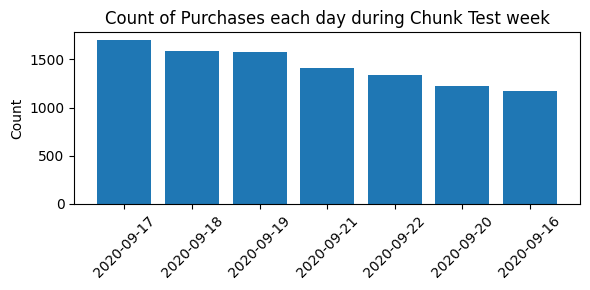

In [19]:
b = chunk_of_test_set['t_dat'].value_counts().reset_index(name='n_purchases')

plt.figure(figsize=(6, 3))
plt.bar(b['t_dat'], b['n_purchases'])

plt.ylabel('Count')
plt.title('Count of Purchases each day during Chunk Test week')
plt.xticks(rotation=45) # Rotate x-axis labels if they are long
plt.tight_layout()
plt.show()

In [36]:
# How many users are in test_set but are not in train set? (They are users without history purchases). 
train_users = set(test_customers_in_train["customer_id"].unique())

test_old = chunk_of_test_set[chunk_of_test_set["customer_id"].isin(train_users)]
test_new = chunk_of_test_set[~chunk_of_test_set["customer_id"].isin(train_users)]

# 2. 
p_old = len(test_old) / len(chunk_of_test_set)
p_new = len(test_new) / len(chunk_of_test_set)
print(f"Users with history of purchases: {p_old:.2%}, New users: {p_new:.2%}")

Users with history of purchases: 92.45%, New users: 7.55%


In [40]:
test_customers_in_train["customer_id"].nunique()

8248

### Purchases Analysis

"target week window" Let's look at the behavior in it to understand what in the past data (features) can explain the purchases.

In [56]:
def top_analysis(target_week, history_set):
    ''' Can we cover top purchases during the test week by tops purchases from train set? '''

    # Compare top_articles_test_week и top_articles_train_set. (What is consistently popular?)
    N = 20 #100, 500
    top_test = (target_week['article_id'].value_counts().head(N))
    top_train = (history_set['article_id'].value_counts().head(N))
    common = set(top_test) & set(top_train)
    print("Common Top articles:", len(common))
    

    # New articles that bought during test week, but not in past.
    train_articles = set(history_set['article_id'].unique()) # 63.831
    test_articles = set(target_week['article_id'].unique()) # 4.573
 
    new_articles = test_articles - train_articles
    print("Num of new articles:", len(new_articles))
    print("Num of articles purchased in history:", len(train_articles))

    target_week['is_new'] = target_week['article_id'].isin(new_articles)

    share_new = target_week['is_new'].mean()
    print("Fraction of new product purchases among all products target week:", share_new)

    # How many new_articles in top_purchased during this week?
    new_in_top = set(new_articles) & set(top_test)
    share_new_in_top = len(new_in_top) / len(top_test)

    print("New articles in Top target week:", new_in_top)
    print("Fraction of new products in the top:", share_new_in_top)

    #### That is, it does not make it into the general top. Maybe it will coincide with the top of last week?

    window_start = '2020-06-16' #'2020-08-06' # '2020-09-09' # 30 days 
    window_df = history_set[(history_set['t_dat'] >= window_start)]

    top_last_week = ( window_df.groupby("article_id")["customer_id"].count().sort_values(ascending=False).head(N)
                        .index.tolist())

    common = set(top_test) & set(top_train)
    print("Common Top articles:", len(common))
    

In [88]:
653 / (63831+653)

0.010126543018423174

In [57]:
top_analysis(chunk_of_test_set, test_customers_in_train)

Common Top articles: 0
Num of new articles: 653
Num of articles purchased in history: 63831
Fraction of new product purchases among all products target week: 0.1146
New articles in Top target week: set()
Fraction of new products in the top: 0.0
Common Top articles: 0


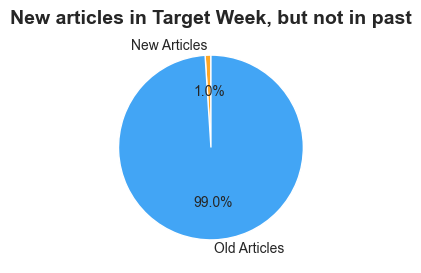

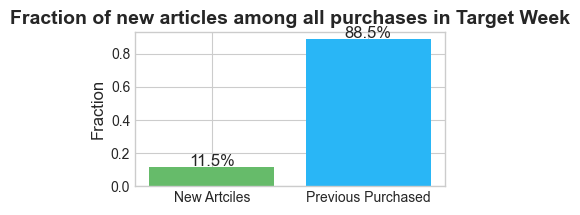

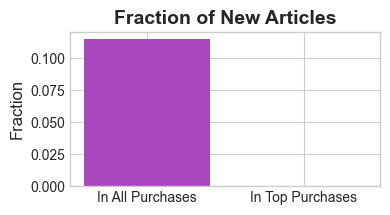

In [93]:
# Visualization
def visulization():
    
    num_new_articles = 653
    num_old_articles = 63831 
    fraction_new_purchases = 0.1146
    fraction_old_purchases = 1 - fraction_new_purchases
    
    #  plt.style.use("seaborn-v0_8-whitegrid")  
    
    # 1. New purchased unique articles that purchased during the test week but not in train. 
    # 
    fig, ax = plt.subplots(figsize=(3,3))
    ax.pie([num_new_articles, num_old_articles], 
           labels=["New Articles", "Old Articles"], 
           autopct="%1.1f%%", 
           colors=["#FFA726", "#42A5F5"], 
           startangle=90, 
           wedgeprops={"edgecolor":"white"})
    ax.set_title("New articles in Target Week, but not in past", fontsize=14, fontweight="bold")
    plt.show()

    # 2. Fraction of new product purchases among all products target week:
    fig, ax = plt.subplots(figsize=(4,2))
    ax.bar(["New Artciles", "Previous Purchased"], 
           [fraction_new_purchases, fraction_old_purchases], 
           color=["#66BB6A", "#29B6F6"])
    ax.set_title("Fraction of new articles among all purchases in Target Week", fontsize=14, fontweight="bold")
    ax.set_ylabel("Fraction", fontsize=12)
    for i, val in enumerate([fraction_new_purchases, fraction_old_purchases]):
        ax.text(i, val + 0.01, f"{val:.1%}", ha="center", fontsize=12)
    plt.show()

    # 3. Fraction of new products in the top
    fig, ax = plt.subplots(figsize=(4,2))
    ax.bar(["In All Purchases", "In Top Purchases"], 
           [fraction_new_purchases, 0], 
           color=["#AB47BC", "#EF5350"])
    ax.set_title("Fraction of New Articles", fontsize=14, fontweight="bold")
    ax.set_ylabel("Fraction", fontsize=12)
    #for i, val in enumerate([fraction_new_purchases, 0]):
    #    ax.text(i, val + 0.01, f"{val:.1%}", ha="center", fontsize=12)
    plt.show()
visulization()

### Can we rely on train_set at all? Here we moving slowly to analysis of potencial candidates. 

In [107]:
# So we saw on graph above that 85% purchases on test week show the most articles were bought before. So let's focus on them for now. 
# Later we'll analyse on 1% of unique articles that were 11% of purchases on target week. 
# Let's check this:
# - can we cover these 85% purchases on test week by the Top articles past week from train set? 2 weeks? Month?

# 3.Check Coverage for diffrent N.
def coverage(target_purchases, window_df, Nv):
    # top_articles = set(train_top.head(top_n)['article_id'])
    top_wind = ( window_df.groupby("article_id")["customer_id"].count()
                .sort_values(ascending=False).head(Nv)
                .index.tolist())
    covered = target_purchases.isin(top_wind).sum()
    return covered / len(target_purchases)


2018-09-20 2020-09-15
2020-08-06 2020-09-15
2020-09-02 2020-09-15
2020-09-09 2020-09-15


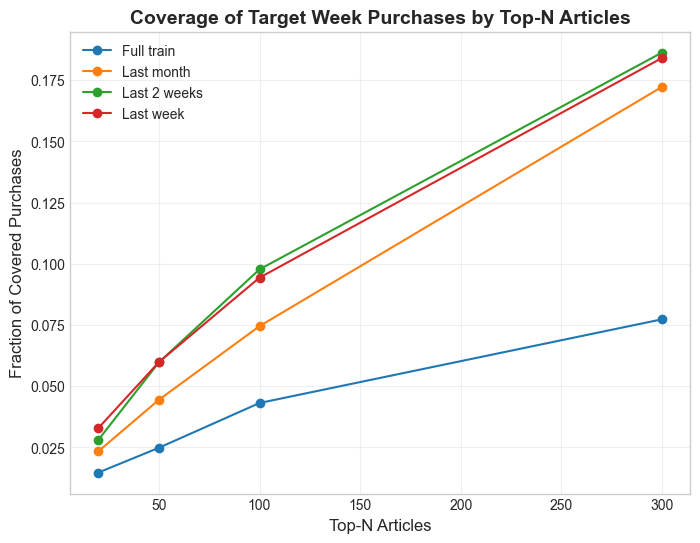

In [104]:
end_date = train_set["t_dat"].max()
#one_week_ago = end_date - pd.Timedelta(days=7)
#one_month_ago = end_date - pd.Timedelta(days=30)

one_week_ago = '2020-09-09'
two_weeks_ago = '2020-09-02'
one_month_ago = '2020-08-06'


windows = {
    "Full train": train_set["t_dat"].min(),
    "Last month": one_month_ago,
    "Last 2 weeks": two_weeks_ago,
    "Last week": one_week_ago,
}

#windows = [one_week_ago, two_weeks_ago, one_month_ago]
tr_set = test_customers_in_train.copy() 
target_purchases = chunk_of_test_set['article_id']

N = [20, 50, 100, 300]
plt.figure(figsize=(8,6))

for label, window_start in windows.items():
    window_df = tr_set[(tr_set['t_dat'] >= window_start)]
    print(window_df['t_dat'].min(), window_df['t_dat'].max())


    #c = coverage(target_purchases, top_wind)
    coverages = [coverage(target_purchases, window_df, n) for n in N]
    plt.plot(N, coverages, marker="o", label=label)


plt.title("Coverage of Target Week Purchases by Top-N Articles", fontsize=14, fontweight="bold")
plt.xlabel("Top-N Articles", fontsize=12)
plt.ylabel("Fraction of Covered Purchases", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Does personal history cover user purchases during Target Week?

In [110]:
history_list_g = tr_set.groupby('customer_id')['article_id'].apply(list).reset_index(name='article_id_history')

# List of articles for each user in Random order. 
test_list_g = chunk_of_test_set.groupby('customer_id')['article_id'].apply(list).reset_index(name='article_id_test')


In [111]:
test_list_g = test_list_g.merge(history_list_g, on='customer_id', how='left')

In [112]:
def calc_metrics(row):
    history_list = row['article_id_history']
    test_list = row['article_id_test']
    
    history_set = set(history_list) if isinstance(history_list, (list, pd.Series, np.ndarray)) else set()
    test_set = set(test_list) if isinstance(test_list, (list, pd.Series, np.ndarray)) else set()
    
    if len(test_set) == 0:
        coverage_ratio = 0
        overlap_ratio = 0
    else:
        coverage_ratio = len(history_set & test_set) / len(test_set)  # Test week purchasess from train history  
        overlap_ratio = len(history_set & test_set) / len(history_set) if len(history_set) > 0 else 0  # history cover test
    
    return pd.Series({'coverage_ratio': coverage_ratio, 'overlap_ratio': overlap_ratio})


test_list_g[['coverage_ratio', 'overlap_ratio']] = test_list_g.apply(calc_metrics, axis=1)

In [113]:
test_list_g.head(5)

,customer_id,article_id_test,article_id_history,coverage_ratio,overlap_ratio
0,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,[915529005],"[676387001, 685687003, 662980003, 529953001, 7...",0.0,0.0
1,0026ebdd70715d8fa2befa14dfed317a1ffe5451aba839...,[759465001],"[700761011, 680262001, 859105003, 714790017, 8...",0.0,0.0
2,003ca8034fe32b9bab8e1c03d74c972abd80dccf84a302...,[895376004],"[613246001, 579865003, 624645006, 623347003, 6...",0.0,0.0
3,00465ec96dd32dca19f85108cbce142de6667a7ace8208...,[862103001],"[688873001, 688873004, 641620001, 600274006, 6...",0.0,0.0
4,004c3751ed6f9dfc98b870291c95be6702d3afa97d9467...,[891763004],"[772988001, 490113011, 612481007, 726537001, 5...",0.0,0.0


In [114]:
# For which users does the history completely match the purchases? (coverage_ratio ≈ overlap_ratio ≈ 1)

# Filter users who have both coverage_ratio and overlap_ratio almost 1
perfect_users = test_list_g[(test_list_g['coverage_ratio'] > 0.0) & (test_list_g['overlap_ratio'] > 0.0)]

# perfect_users.head(10)
perfect_users['customer_id'].nunique() # 416
test_list_g['customer_id'].nunique() # 8937

8937

In [115]:
416 / 8937

0.046548058632650775

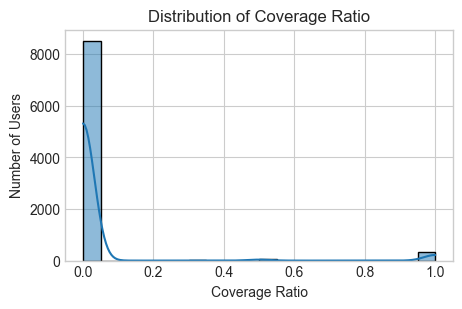

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,3))
sns.histplot(test_list_g['coverage_ratio'], bins=20, kde=True)
plt.xlabel('Coverage Ratio')
plt.ylabel('Number of Users')
plt.title('Distribution of Coverage Ratio')
plt.show()

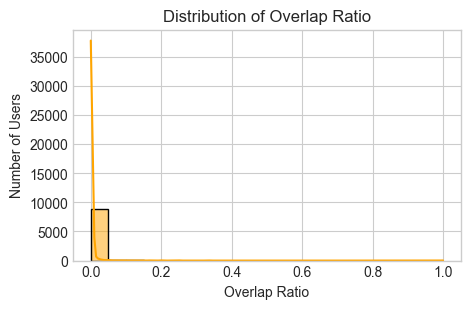

In [117]:
plt.figure(figsize=(5,3))
sns.histplot(test_list_g['overlap_ratio'], bins=20, kde=True, color='orange')
plt.xlabel('Overlap Ratio')
plt.ylabel('Number of Users')
plt.title('Distribution of Overlap Ratio')
plt.show()

In [ ]:
#  Conclusion:
# Only 4.6% users their history completely match the purchases.
# But before we saw 85% coverage all purchases in target week. 

# So this gives us an understanding that most users don't buy the same articles repeatedly, and gives us an important signal to pay attention to overall top articles rather than personal purchase history.

# We need to look for global or contextual signals that will help predict purchases. Like we did early about TopN last week. 

### co-purchase ? Let's analyze. 

This means that if a user buys one item, we can recommend products that were often bought together with it by other users.    
Step 1: Collect all purchases by transaction.   
Step 2: Calculate joint purchases.   
Step 3: Build recommendations.     
Step 4: Use for user. If user bought item A in cart, recommend to user based on related purchases.

In [124]:
# train_set: customer_id, article_id
# Can be grouped by carts (e.g. by user_id and purchase date)
basket = tr_set.groupby(['customer_id', 't_dat'])['article_id'].apply(list).reset_index()

# Idea: for each pair of articles (i,j) count how many times they appeared in the same basket:
from collections import defaultdict
from itertools import combinations

co_purchase_counts = defaultdict(int)

for items in basket['article_id']:
    for i, j in combinations(items, 2):
        co_purchase_counts[(i,j)] += 1
        co_purchase_counts[(j,i)] += 1  # is that the pairs are bilateral


In [125]:
# co_purchase_counts
# Step 3: Build recommendations.
# For each article i:
top_co_items = {}
for i, j in co_purchase_counts:
    if i not in top_co_items:
        top_co_items[i] = []
    top_co_items[i].append((j, co_purchase_counts[(i,j)]))

# Sort by number of joint purchases. 
for i in top_co_items:
    top_co_items[i] = sorted(top_co_items[i], key=lambda x: x[1], reverse=True)
# Now for any article i we can take the top-N articles j that were most often purchased together with it.


In [126]:
user_history_items = tr_set.groupby('customer_id')['article_id'].apply(list).to_dict()
# user_history_items is the same history_list_g. 

user_test_items = chunk_of_test_set.groupby('customer_id')['article_id'].apply(list).to_dict()

In [129]:
# Step 4: Use for user. If user bought item A in cart, recommend to user based on related purchases.
user_co_candidates = []
for item in b:
    if item in top_co_items:
        user_co_candidates.extend([j for j, _ in top_co_items[item][:5]])  # топ-5 co-purchase
len(user_co_candidates)

# user_co_candidates → candidates that can be recommended to the user based on related purchases.

465